In [2]:
%load_ext autoreload

%autoreload 2
import GCRCatalogs
import matplotlib.pyplot as plt
import pickle
import sys
from astropy.table import QTable, Table, vstack, join, hstack 
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Mass_richness_relation as mr

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
down, up, n_bins = 0.1 , 15,40
bin_edges = make_bins(down, up, nbins=n_bins, method='evenlog10width')
radial_bin = binning(bin_edges)

In [4]:
radial_bin_mid = np.mean(radial_bin, axis = 1)

In [5]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [6]:
profile_epsilon = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/SkySim5000/SkySim5000_epsilon_shape_all_bins_ns.pkl')

In [7]:
m_SORT = np.sort(np.array(profile_epsilon['M200c']), axis = 0)

In [9]:
m_list = np.array_split(m_SORT,5)
m_corner = []
for m_ in m_list:
    m_corner.append(m_[0][0])
m_corner.append(np.inf)

In [11]:
z_corner = np.linspace(0.2, 0.7 ,6)
Z_bin = binning(z_corner)
Mass_bin = binning(m_corner)
print(Z_bin), print(np.log10(Mass_bin))

[[0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7]]
[[14.00015875 14.04929408]
 [14.04929408 14.10537088]
 [14.10537088 14.18440278]
 [14.18440278 14.31029049]
 [14.31029049         inf]]


(None, None)

# WL shear profiles 

In [12]:
profile_stack_epsilon = prf.stacked_profile(profile = profile_epsilon,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_stack_epsilon = prf.bootstrap_covariance(profile = profile_epsilon,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 300,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_DATAOPS_make_profile.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return gt_w/w, gx_w/w, r_w/w
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_DATAOPS_make_profile.py:35: RuntimeWarning: invalid value encountered in true_divide
  return gt_w/w, gx_w/w, r_w/w
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [13]:
m_av_gamma = []
for p in profile_stack_epsilon:
    m_av_gamma.append(np.mean(np.array(p['obs_individual']**0.75))**(1/0.75))

In [14]:
profile_stack_epsilon['obs_mean_gamma'] = np.array(m_av_gamma)

In [17]:
a_value = 0#(1.53 + 1*0.25)
b_value = 1#(0.38 + 1*0.10)
fit_200c_epsilon_1h_free_c = fit.fit_WL_cluster_mass(profile = profile_stack_epsilon, covariance = covariance_stack_epsilon, a = a_value, b = b_value, rmax = 10, two_halo_term = True, fix_c = False)
#fit_200c_epsilon_2h_free_c = fit(profile = profile_stack_epsilon, covariance = covariance_stack_epsilon, a = a_value, b = b_value, rmax = 15, two_halo_term = True, fix_c = False)
#fit_200c_epsilon_1h_fix_c  = fit(profile = profile_stack_epsilon, covariance = covariance_stack_epsilon, a = a_value, b = b_value, rmax = 5.5, two_halo_term = False, fix_c = True)
#fit_200c_epsilon_2h_fix_c  = fit(profile = profile_stack_epsilon, covariance = covariance_stack_epsilon, a = a_value, b = b_value, rmax = 15, two_halo_term = True, fix_c = True)#

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_NFW_profile.py:25: RuntimeWarning: invalid value encountered in double_scalars
  self.rdelta = ((3*self.M) / (4*np.pi*self.delta*self.alpha* self.rho_critical)) ** (1./3.)
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_NFW_profile.py:35: RuntimeWarning: invalid value encountered in log
  return np.log(1 + c) - c/(1 + c)


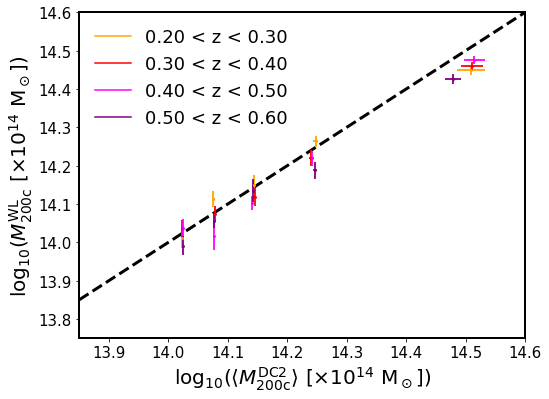

In [22]:
fit_LIST = [fit_200c_epsilon_1h_free_c]
plt.rcParams['axes.linewidth']=2
fit_label = [r'$epsilon$',r'$shear$']
import matplotlib.pyplot as plt
color_fit = ['k','r','b']
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
marker = ['o','x']
plt.figure(figsize = (8,6))
for i, z_bin in enumerate(Z_bin):
    if not (z_bin[0] >= 0.2)*(z_bin[1] < .7):continue
    plt.plot([],[], label = f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}', c = color_z[i])
    for j, f in enumerate(fit_LIST):
        mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
        mask = mask*(np.array(f['n_stack']) > 3)
        mask = mask*(np.array(f['chi2ndof'][i]) > 0.)*(np.array(f['chi2ndof'][i]) < 1000000000)
        f_cut = Table(f)[mask]
        m = f_cut['obs_mean']
        m_err = f_cut['obs_rms']
        logm_err = f_cut['obs_rms']/(np.log(10)*m)
        logm200w = f_cut['logm200_w']
        logm200w_err = f_cut['logm200_w_err']
        plt.errorbar(np.log10(np.array(f_cut['obs_mean_gamma'])), 
                     logm200w, 
                     logm200w_err,logm_err,
                      c=color_z[i],
                    marker = marker[j], fmt= ' ',\
                    elinewidth = 2, capsize = 0, markersize = 2, alpha = 0.9)

ylabel = r'$\log_{10}(M_{\rm 200c}^{\rm WL}$ ' + r'$[\times 10^{14}\ \rm{M}_\odot])$'
xlabel = r'$\log_{10}(\langle M_{\rm 200c}^{\rm DC2} \rangle$ ' + r'$[\times 10^{14}\ \rm{M}_\odot])$'
m = np.linspace(13,15,10)
plt.plot(m,m,'--k',zorder = 1, alpha = 1, linewidth = 3)
plt.xlim(13.85, 14.6)
plt.ylim(13.75, 14.6)
plt.tick_params(axis='both', which = 'major', labelsize= 15, zorder = 0)
plt.xlabel(xlabel, fontsize = 20)
plt.ylabel(ylabel, fontsize = 20)
plt.legend(loc='upper left', frameon = False, fontsize = 18, numpoints = 1)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/M200cw_M200c_2h_fixc.png', bbox_inches='tight', dpi=300)

4 5


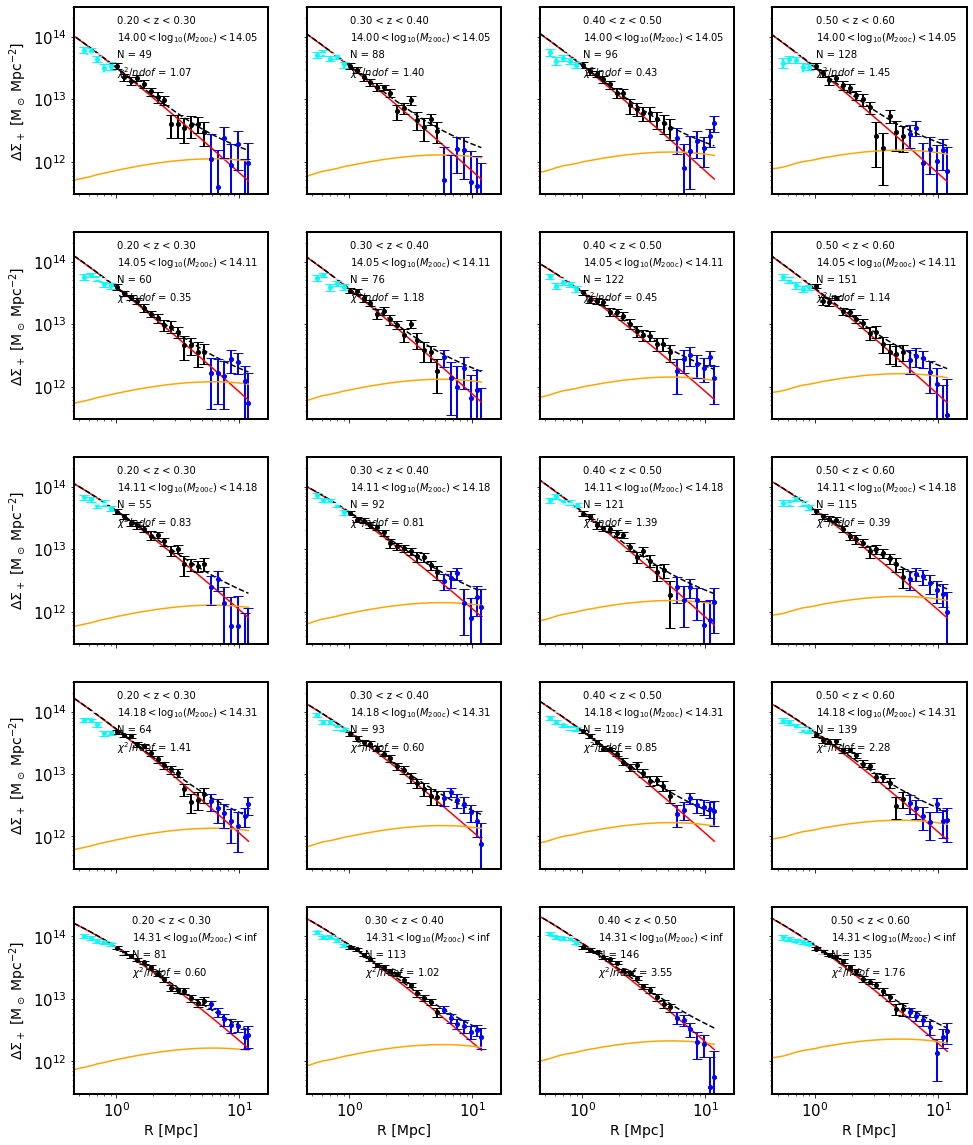

In [24]:
n_z_bin = len(Z_bin) - 1
n_m_bin = len(Mass_bin) - 0
print(n_z_bin, n_m_bin)
scale = 4
fig, axs = plt.subplots(n_m_bin,n_z_bin, figsize = (scale*n_z_bin,scale*n_m_bin))
for j, z_bin in enumerate(Z_bin):

    if j >= n_z_bin: continue
        
    for i, m_bin in enumerate(Mass_bin):

        if i >= n_m_bin: continue
        label_z = f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}'
        label_M = f'{np.log10(m_bin[0]):.2f}' + r'$ < \log_{10}(M_{\rm 200c}) < $' + f'{np.log10(m_bin[1]):.2f}'
        axs[i, j].plot([], [], 'w', label = label_z)
        axs[i, j].plot([], [], 'w', label = label_M)
        c = ['r','b']
        fmt = ['-', '--']
        marker = ['o', 's']
        markersize = [2,2]
        name = ['center cosmoDC2', 'center RedMapper']
        fit = fit_200c_epsilon_1h_free_c
        profile_ = profile_stack_epsilon
        covariance = covariance_stack_epsilon
        mask_z = (profile_['z_mean'] > z_bin[0])*(profile_['z_mean'] < z_bin[1])
        mask_m = (profile_['obs_mean'] > m_bin[0])*(profile_['obs_mean'] < m_bin[1])
        index = np.arange(len(profile_['z_mean']))
        index_cut = index[mask_m * mask_z]
        fit_cut = Table(fit)[index_cut]
        profile_cut = profile_[mask_m * mask_z]
        try:
            gt_err = np.sqrt(np.array(covariance[index_cut]['cov_t'].T.diagonal())[0])
        except: break
        axs[i, j].plot(fit_cut['radius_model'][0], fit_cut['1h_term'][0], '-', c = 'r')
        axs[i, j].plot(fit_cut['radius_model'][0], fit_cut['2h_term'][0], '-', c = 'orange')
        axs[i, j].plot(fit_cut['radius_model'][0], fit_cut['1h_term'][0] + fit_cut['2h_term'][0],'--', c = 'k')
        low = a_value*fit_cut['z_mean'] + b_value
        mask_att = (fit_cut['radius_model'][0] < low)*(fit_cut['radius_model'][0] > 0.5)
        mask_1h = (fit_cut['radius_model'][0] < 5.5)*(fit_cut['radius_model'][0] > low)*(fit_cut['radius_model'][0] > 0.5)
        mask_2h = (fit_cut['radius_model'][0] > 5.5)*(fit_cut['radius_model'][0] > 0.5)
        axs[i, j].errorbar(fit_cut['radius_model'][0][mask_1h], profile_cut['gt'][0][mask_1h],gt_err[mask_1h], c = 'k'
                           ,marker = 'o',fmt = ' ', elinewidth = 2, capsize = 5, markersize = 4, markerfacecolor = None)
        axs[i, j].errorbar(fit_cut['radius_model'][0][mask_2h], profile_cut['gt'][0][mask_2h],gt_err[mask_2h], c = 'b'
                           ,marker = 'o',fmt = ' ', elinewidth = 2, capsize = 5, markersize = 4, markerfacecolor = None)
        axs[i, j].errorbar(fit_cut['radius_model'][0][mask_att], profile_cut['gt'][0][mask_att],gt_err[mask_att], c = 'cyan'
                           ,marker = 'o',fmt = ' ', elinewidth = 2, capsize = 5, markersize = 4, markerfacecolor = None)
        n = fit_cut['n_stack'][0]
        label_n = f'N = {n:.0f}'
        axs[i, j].plot([], [], 'w', label = label_n)
        chi = fit_cut['chi2ndof'][0]
        label_n = f'$\chi^2/ndof$ = {chi:.2f}'
        axs[i, j].plot([], [], 'w', label = label_n)
        axs[i, j].set_ylim(3e11, 3e14)
        axs[i, j].set_xlim(0.45, 17)
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].tick_params(axis='both', which = 'major', labelsize= 15)
        axs[i, j].legend(frameon = False, loc = 'upper right', fontsize = 10)
        axs[i, j].set_xlabel('R [Mpc]', fontsize = 14)
        axs[i, j].set_ylabel(r'$\Delta\Sigma_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 14)

for ax in fig.get_axes():
    ax.label_outer()
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/profile_excess_surface_density.png', bbox_inches='tight', dpi=300)

In [ ]:
plt.hist(fit_200c_epsilon_2h_free_c['chi2ndof'])